In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
import requests
from urllib.parse import urlparse
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'
import gc
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
font_path = './NanumFontSetup_TTF_BARUNGOTHIC/NanumBarunGothic.ttf'
import matplotlib.font_manager as fm
fontprop = fm.FontProperties(fname=font_path, size=18)
import shap
import seaborn as sns

In [2]:
%%time
# Read Data
basedir = './Training/training_data_ver_16/'
training_data_df = pd.read_csv(basedir + 'training_data_ver_16.csv').drop(columns=['주택가격지수']).dropna()
#training_data_df = training_data_df[(training_data_df['가격면적'] >= 200) & (training_data_df['가격면적'] <= 1500)]
training_data_df.columns = [col.replace(' ','_').replace('·','_') for col in training_data_df.columns]
print(training_data_df.shape)
training_data_df.head()

(3857227, 403)
Wall time: 1min 24s


,전용면적,금액(만원),층,건축년도,가격면적,target_log_transformed,targetarea_log_transformed,지번주소,전용면적_mean,전용면적_min,전용면적_max,건물나이,year_linear,month_sin,month_cos,xnorm,ynorm,x_2nd,y_2nd,x_sin,y_sin,x_cos,y_cos,xy,trade_type,공시지가(만원),표준지여부,철근콘크리트구조_fraction,철골철근콘크리트구조_fraction,벽돌구조_fraction,프리케스트콘크리트구조_fraction,경량철골구조_fraction,철골콘크리트구조_fraction,일반철골구조_fraction,블록구조_fraction,일반목구조_fraction,기타조적구조_fraction,기타강구조_fraction,강파이프구조_fraction,기타구조_fraction,석구조_fraction,기타콘크리트구조_fraction,라멘조_fraction,조립식판넬조_fraction,주_용도_공동주택_fraction,주_용도_종교시설_fraction,주_용도_제2종근린생활시설_fraction,주_용도_단독주택_fraction,주_용도_제1종근린생활시설_fraction,주_용도_교육연구시설_fraction,주_용도_판매시설_fraction,주_용도_노유자시설_fraction,주_용도_자동차관련시설_fraction,주_용도_업무시설_fraction,주_용도_운동시설_fraction,주_용도_창고시설_fraction,주_용도_문화및집회시설_fraction,주_용도_숙박시설_fraction,주_용도_근린생활시설_fraction,주_용도_위험물저장및처리시설_fraction,주_용도_동.식물관련시설_fraction,주_용도_의료시설_fraction,주_용도_공장_fraction,주_용도_관광휴게시설_fraction,주_용도_수련시설_fraction,주_용도_판매및영업시설_fraction,주_용도_교육연구및복지시설_fraction,지붕_평지붕_fraction,지붕_철콘지붕_fraction,지붕_경사지붕_fraction,지붕_기타지붕_fraction,지붕_기와지붕_fraction,지붕_판넬지붕_fraction,지붕_박공지붕_fraction,지붕_모임지붕_fraction,지붕_스페니쉬기와_fraction,지붕_슬레이트지붕_fraction,지붕_초가지붕_fraction,지붕_멘사드지붕_fraction,지붕_철골지붕_fraction,지붕_함석지붕_fraction,지붕_목구조지붕_fraction,지붕_원형지붕_fraction,지붕_금속지붕_fraction,지붕_전통지붕_fraction,지붕_비닐지붕_fraction,총외필지수,총건축면적,총연면적,총용적률연면적,총호수,주건축물수,부속건축물수,부속건축물면적,옥내기계식대수,옥외기계식대수,옥내자주식대수,옥외자주식대수,총주차수,epi점수,친환경점수,호수대비연면적,호수대비주차수,층min,층max,층mean,층median,층norm,지하세대있음,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,(한강)오염행위_제한지역,(한강)폐기물매립시설_설치제한지역,4대문안,가로구역별_최고높이_제한지역,가스공급설비,가축사육제한구역,개발제한구역,개발진흥지구,개발행위허가제한지역,건축선,건축용도지역기타,건축용도지역미분류,건축허가_착공제한지역,경관광장,경관녹지,경관지구,경관지구기타,고도지구,고등학교,고속철도,공공공지,공공도서관,공공문화체육시설미분류,공공시설구역,공공주택지구,공공지원민간임대주택_공급촉진지구,공공청사,공동구,공용시설보호지구,공원,공원마을지구(공원집단시설지구),공원자연보존지구,공원자연환경지구,공익용산지,공익임지,공장설립승인지역,공장설립제한지역,공항소음피해예상지역,공항시설보호지구,과밀억제권역,광로1류(폭_70M_이상),광로2류(폭_50M~70M),광로3류(폭_40M~50M),광역계획구역,광장,교육환경보호구역,교통광장,국가산업단지,국가지정문화재구역,국가하천,국립공원,국민임대주택단지예정지구,국지도로,국토이용기타용도지구,국토이용용도지구기타,근린공원,근린광장,근린상업지역,기타공공공지시설,기타공공청사시설,기타공원시설,기타교통시설,기타녹지시설,기타도로시설,기타도시공간시설,기타문화시설,기타보건위생시설,기타수도시설,기타시장시설,기타용도지역지구기타,기타용지,기타유통및공급시설,기타유통업무설비,기타자동차정류장,기타주차장시설,기타철도시설,기타폐기물처리시설,노외주차장,녹지,대공방어협조구역,대공방어협조구역(위탁고도54-236m),대공방어협조구역(위탁고도77-257m),대로1류(폭_35M~40M),대로2류(폭_30M~35M),대로3류(폭_25M~30M),대학,도로,도로구역,도서관,도시개발구역,도시개발구역기타,도시고속도로,도시관리계획_입안중,도시기타용도지역지구기타,도시기타용도지역지구미분류,도시기타용도지역지구용도지역지구,도시자연공원,도시자연공원구역,도시지역,도시지역기타,도시철도,묘지공원,문화공원,문화시설,문화재,문화재보존영향_검토대상구역,문화재보호구역,문화재보호구역기타,문화지구,박물관,방송통신시설,방수설비,방재지구,방화지구,변전소(전원개발사업구역),변전시설,보전산지,보전임지,보존지구,보행자전용도로,부설주차장,비오톱1등급,비행안전제2구역(전술),비행안전제2구역(지원),비행안전제3구역(전술),비행안전제3구역(지원),비행안전제4구역(지원),비행안전제5구역(전술),비행안전제5구역(지원),비행안전제6구역(전술),사고지,사방시설,사방지,사업지역기타,사업지역미분류,사회복지시설,산업개발진흥지구,산업시설구역,상대보호구역,상대정화구역,상수원보호구역,상수원보호기타,생산녹지지역,소공원,소로1류(폭_10M~12M),소로2류(폭_8M~10M),소로3류(폭_8M_미만),소하천,소하천구역,수도공급시설,수평표면구역,시_도_생태_경관보전지역,시가지경관지구,시가지조성사업지역,시도지정문화재구역,시장,시장정비구역,시장정비구역기타,아파트지구,야생생물보호구역,어린이공원,여객자동차터미널,역사도심,역사문화미관지구,역사문화특화경관지구,역사문화환경보존지역,연결녹지,연구개발특구,연구시설,열공급설비,온천공보호구역,완충녹지,용도구역기타,용도구역미분류,운동장,원추표면구역,원형보존지,유수지,유원지,유치원,유통단지,유통상업지역,유통업무설비,일단의공업용지조성사업지역,일단의주택단지조성사업지역,일반도로,일반미관지구,일반산업단지,일반상업지역,일반주거지역,일반철도,임업용산지,자동차검사시설,자동차전용도로,자동차정류장,자연경관지구,자연녹지지역,자연재해위험지구,장애물제한표면구역,재개발구역,재개발구역기타,재정비촉진지구,재정비촉진지구기타,저류시설,전기공급설비,전용주거지역,전이표면구역,전통사찰보존구역,절대보호구역,절대정화구역,정비구역,정비구역기타,정비예정구역,제1종일반주거지역,제1종전용주거지역,제1종지구단위계획구역,제2종일반주거지역,제2종전용주거지역,제3종_구역,제3종일반주거지역,제방,제한보호구역,제한보호구역(전술항공5km),제한보호구역(후방지역500m),조례로정한지역,조망가로미관지구,조망가로특화경관지구,종합의료시설,주간선도로,주거용지,주거환경개선지구,주차장,주차장기타,주차환경개선지구,준공업지역,준보전산지,준주거지역,중로1류(폭_20M~25M),중로2류(폭_15M~20M),중로3류(폭_12M~15M),중심대광장,중심상업지역,중심지미관지구,중요시설물보존지구,중요시설물보호지구,중요시설물보호지구(공용),중요시설물보호지구(공항),중점경관관리구역,중학교,지구단위계획구역,지역특화발전특구,지원시설구역,지정문화재구역,지하광장,지하도로,진입표면구역,집단취락지구,철도,청사,청소년수련시설,체육공원,체육시설,초등학교,최고고도지구,침수위험지구,택지개발예정지구,택지개발예정지구기타,토지거래계약에관한허가구역,토지구획정리사업지구기타,통제보호구역,통제보호구역(민통선이남300m),특수도로(보행자전용도로),특정개발진흥지구,특화경관지구,폐기물처리및재활용시설,폐기물처리시설,하수도,하수종말처리시설,하천,하천구역,학교,학교시설보호지구,학교이적지,학교환경위생_정화구역,현상변경허가_대상구역,홍수관리구역
0,77.75,57000.0,2,1988,733.118971,10.950807,6.597308,서울특별시 강남구 개포동 655-2,77.75,77.75,77.75,0,7.666667,-0.866025,-0.500000,5579.095707,-9048.95

<AxesSubplot:>

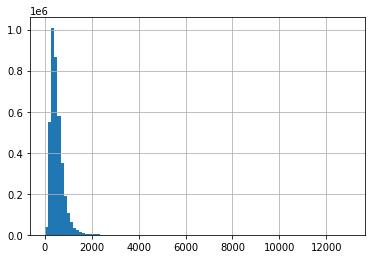

In [3]:
training_data_df['가격면적'].hist(bins=100)

In [4]:
training_data_df['가격면적'].describe()

count    3.857227e+06
mean     5.085237e+02
std      2.754056e+02
min      1.402464e+01
25%      3.243679e+02
50%      4.486317e+02
75%      6.229605e+02
max      1.300000e+04
Name: 가격면적, dtype: float64

In [5]:
training_data_df = training_data_df[(training_data_df['가격면적'] >= 200) & (training_data_df['가격면적'] <= 3000)]
print(training_data_df.shape)
training_data_df.head()

(3672159, 403)


,전용면적,금액(만원),층,건축년도,가격면적,target_log_transformed,targetarea_log_transformed,지번주소,전용면적_mean,전용면적_min,전용면적_max,건물나이,year_linear,month_sin,month_cos,xnorm,ynorm,x_2nd,y_2nd,x_sin,y_sin,x_cos,y_cos,xy,trade_type,공시지가(만원),표준지여부,철근콘크리트구조_fraction,철골철근콘크리트구조_fraction,벽돌구조_fraction,프리케스트콘크리트구조_fraction,경량철골구조_fraction,철골콘크리트구조_fraction,일반철골구조_fraction,블록구조_fraction,일반목구조_fraction,기타조적구조_fraction,기타강구조_fraction,강파이프구조_fraction,기타구조_fraction,석구조_fraction,기타콘크리트구조_fraction,라멘조_fraction,조립식판넬조_fraction,주_용도_공동주택_fraction,주_용도_종교시설_fraction,주_용도_제2종근린생활시설_fraction,주_용도_단독주택_fraction,주_용도_제1종근린생활시설_fraction,주_용도_교육연구시설_fraction,주_용도_판매시설_fraction,주_용도_노유자시설_fraction,주_용도_자동차관련시설_fraction,주_용도_업무시설_fraction,주_용도_운동시설_fraction,주_용도_창고시설_fraction,주_용도_문화및집회시설_fraction,주_용도_숙박시설_fraction,주_용도_근린생활시설_fraction,주_용도_위험물저장및처리시설_fraction,주_용도_동.식물관련시설_fraction,주_용도_의료시설_fraction,주_용도_공장_fraction,주_용도_관광휴게시설_fraction,주_용도_수련시설_fraction,주_용도_판매및영업시설_fraction,주_용도_교육연구및복지시설_fraction,지붕_평지붕_fraction,지붕_철콘지붕_fraction,지붕_경사지붕_fraction,지붕_기타지붕_fraction,지붕_기와지붕_fraction,지붕_판넬지붕_fraction,지붕_박공지붕_fraction,지붕_모임지붕_fraction,지붕_스페니쉬기와_fraction,지붕_슬레이트지붕_fraction,지붕_초가지붕_fraction,지붕_멘사드지붕_fraction,지붕_철골지붕_fraction,지붕_함석지붕_fraction,지붕_목구조지붕_fraction,지붕_원형지붕_fraction,지붕_금속지붕_fraction,지붕_전통지붕_fraction,지붕_비닐지붕_fraction,총외필지수,총건축면적,총연면적,총용적률연면적,총호수,주건축물수,부속건축물수,부속건축물면적,옥내기계식대수,옥외기계식대수,옥내자주식대수,옥외자주식대수,총주차수,epi점수,친환경점수,호수대비연면적,호수대비주차수,층min,층max,층mean,층median,층norm,지하세대있음,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,(한강)오염행위_제한지역,(한강)폐기물매립시설_설치제한지역,4대문안,가로구역별_최고높이_제한지역,가스공급설비,가축사육제한구역,개발제한구역,개발진흥지구,개발행위허가제한지역,건축선,건축용도지역기타,건축용도지역미분류,건축허가_착공제한지역,경관광장,경관녹지,경관지구,경관지구기타,고도지구,고등학교,고속철도,공공공지,공공도서관,공공문화체육시설미분류,공공시설구역,공공주택지구,공공지원민간임대주택_공급촉진지구,공공청사,공동구,공용시설보호지구,공원,공원마을지구(공원집단시설지구),공원자연보존지구,공원자연환경지구,공익용산지,공익임지,공장설립승인지역,공장설립제한지역,공항소음피해예상지역,공항시설보호지구,과밀억제권역,광로1류(폭_70M_이상),광로2류(폭_50M~70M),광로3류(폭_40M~50M),광역계획구역,광장,교육환경보호구역,교통광장,국가산업단지,국가지정문화재구역,국가하천,국립공원,국민임대주택단지예정지구,국지도로,국토이용기타용도지구,국토이용용도지구기타,근린공원,근린광장,근린상업지역,기타공공공지시설,기타공공청사시설,기타공원시설,기타교통시설,기타녹지시설,기타도로시설,기타도시공간시설,기타문화시설,기타보건위생시설,기타수도시설,기타시장시설,기타용도지역지구기타,기타용지,기타유통및공급시설,기타유통업무설비,기타자동차정류장,기타주차장시설,기타철도시설,기타폐기물처리시설,노외주차장,녹지,대공방어협조구역,대공방어협조구역(위탁고도54-236m),대공방어협조구역(위탁고도77-257m),대로1류(폭_35M~40M),대로2류(폭_30M~35M),대로3류(폭_25M~30M),대학,도로,도로구역,도서관,도시개발구역,도시개발구역기타,도시고속도로,도시관리계획_입안중,도시기타용도지역지구기타,도시기타용도지역지구미분류,도시기타용도지역지구용도지역지구,도시자연공원,도시자연공원구역,도시지역,도시지역기타,도시철도,묘지공원,문화공원,문화시설,문화재,문화재보존영향_검토대상구역,문화재보호구역,문화재보호구역기타,문화지구,박물관,방송통신시설,방수설비,방재지구,방화지구,변전소(전원개발사업구역),변전시설,보전산지,보전임지,보존지구,보행자전용도로,부설주차장,비오톱1등급,비행안전제2구역(전술),비행안전제2구역(지원),비행안전제3구역(전술),비행안전제3구역(지원),비행안전제4구역(지원),비행안전제5구역(전술),비행안전제5구역(지원),비행안전제6구역(전술),사고지,사방시설,사방지,사업지역기타,사업지역미분류,사회복지시설,산업개발진흥지구,산업시설구역,상대보호구역,상대정화구역,상수원보호구역,상수원보호기타,생산녹지지역,소공원,소로1류(폭_10M~12M),소로2류(폭_8M~10M),소로3류(폭_8M_미만),소하천,소하천구역,수도공급시설,수평표면구역,시_도_생태_경관보전지역,시가지경관지구,시가지조성사업지역,시도지정문화재구역,시장,시장정비구역,시장정비구역기타,아파트지구,야생생물보호구역,어린이공원,여객자동차터미널,역사도심,역사문화미관지구,역사문화특화경관지구,역사문화환경보존지역,연결녹지,연구개발특구,연구시설,열공급설비,온천공보호구역,완충녹지,용도구역기타,용도구역미분류,운동장,원추표면구역,원형보존지,유수지,유원지,유치원,유통단지,유통상업지역,유통업무설비,일단의공업용지조성사업지역,일단의주택단지조성사업지역,일반도로,일반미관지구,일반산업단지,일반상업지역,일반주거지역,일반철도,임업용산지,자동차검사시설,자동차전용도로,자동차정류장,자연경관지구,자연녹지지역,자연재해위험지구,장애물제한표면구역,재개발구역,재개발구역기타,재정비촉진지구,재정비촉진지구기타,저류시설,전기공급설비,전용주거지역,전이표면구역,전통사찰보존구역,절대보호구역,절대정화구역,정비구역,정비구역기타,정비예정구역,제1종일반주거지역,제1종전용주거지역,제1종지구단위계획구역,제2종일반주거지역,제2종전용주거지역,제3종_구역,제3종일반주거지역,제방,제한보호구역,제한보호구역(전술항공5km),제한보호구역(후방지역500m),조례로정한지역,조망가로미관지구,조망가로특화경관지구,종합의료시설,주간선도로,주거용지,주거환경개선지구,주차장,주차장기타,주차환경개선지구,준공업지역,준보전산지,준주거지역,중로1류(폭_20M~25M),중로2류(폭_15M~20M),중로3류(폭_12M~15M),중심대광장,중심상업지역,중심지미관지구,중요시설물보존지구,중요시설물보호지구,중요시설물보호지구(공용),중요시설물보호지구(공항),중점경관관리구역,중학교,지구단위계획구역,지역특화발전특구,지원시설구역,지정문화재구역,지하광장,지하도로,진입표면구역,집단취락지구,철도,청사,청소년수련시설,체육공원,체육시설,초등학교,최고고도지구,침수위험지구,택지개발예정지구,택지개발예정지구기타,토지거래계약에관한허가구역,토지구획정리사업지구기타,통제보호구역,통제보호구역(민통선이남300m),특수도로(보행자전용도로),특정개발진흥지구,특화경관지구,폐기물처리및재활용시설,폐기물처리시설,하수도,하수종말처리시설,하천,하천구역,학교,학교시설보호지구,학교이적지,학교환경위생_정화구역,현상변경허가_대상구역,홍수관리구역
0,77.75,57000.0,2,1988,733.118971,10.950807,6.597308,서울특별시 강남구 개포동 655-2,77.75,77.75,77.75,0,7.666667,-0.866025,-0.500000,5579.095707,-9048.95

<AxesSubplot:>

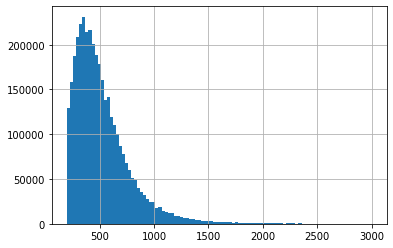

In [6]:
training_data_df['가격면적'].hist(bins=100)

In [7]:
training_data_df['호수대비부속건축물면적'] = training_data_df['부속건축물면적'] / training_data_df['총호수']

In [8]:
training_data_df = training_data_df[(training_data_df['호수대비부속건축물면적'] < 100)]

In [9]:
training_data_df.shape

(3658226, 404)

In [10]:
training_data_df = training_data_df.reset_index(drop=True)

In [11]:
cols_to_log = ['총건축면적', '총연면적', '총용적률연면적', '토지면적', '부속건축물면적']
for col in cols_to_log:
    training_data_df[col] = training_data_df[col].apply(np.log1p)

In [12]:
cat_cols_df = pd.read_csv(basedir + 'cat_cols.csv')
cat_cols_df.head()

,colname
0,trade_type
1,표준지여부
2,건물나이
3,지목명
4,용도지역명1


In [13]:
cat_cols_list = [col.replace(' ','_').replace('·','_') for col in cat_cols_df['colname'].tolist()]
len(cat_cols_list)

296

In [14]:
cat_cols = [col for col in training_data_df.columns if col in cat_cols_list]
len(cat_cols)

296

In [15]:
cat_cols[:10]

['건물나이',
 'trade_type',
 '표준지여부',
 '지목명',
 '용도지역명1',
 '용도지역명2',
 '토지이동상황',
 '지형높이',
 '지형형상',
 '도로접면']

# Training

In [16]:
from sklearn.model_selection import KFold, GroupKFold

In [17]:
import lightgbm as lgb

In [18]:
from sklearn.metrics import r2_score

In [19]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [20]:
target_cols = ['금액(만원)', '가격면적', 'target_log_transformed', 'targetarea_log_transformed', '지번주소']

Fold 0 start
y dist plot


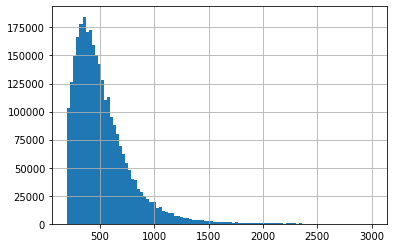

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.984521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10179
[LightGBM] [Info] Number of data points in the train set: 2926580, number of used features: 378


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.640869
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.3562
[100]	valid_0's huber: 64.6145
[150]	valid_0's huber: 58.4715
[200]	valid_0's huber: 54.7555
[250]	valid_0's huber: 52.2162
[300]	valid_0's huber: 50.5519
[350]	valid_0's huber: 49.2716
[400]	valid_0's huber: 48.1596
[450]	valid_0's huber: 47.2232
[500]	valid_0's huber: 46.4398
[550]	valid_0's huber: 45.6931
[600]	valid_0's huber: 44.9615
[650]	valid_0's huber: 44.4696
[700]	valid_0's huber: 43.9226
[750]	valid_0's huber: 43.4728
[800]	valid_0's huber: 43.1014
[850]	valid_0's huber: 42.7183
[900]	valid_0's huber: 42.2996
[950]	valid_0's huber: 41.9203
[1000]	valid_0's huber: 41.5949
[1050]	valid_0's huber: 41.3216
[1100]	valid_0's huber: 41.001
[1150]	valid_0's huber: 40.7479
[1200]	valid_0's huber: 40.4819
[1250]	valid_0's huber: 40.2233
[1300]	valid_0's huber: 40.0182
[1350]	valid_0's huber: 39.8373
[1400]	valid_0's huber: 39.6828
[1450]	v

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


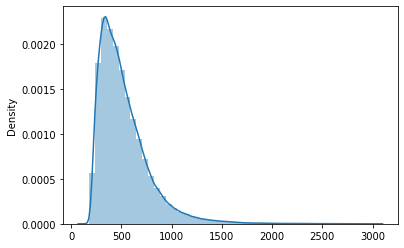

Fold 0 end
Fold 1 start
y dist plot


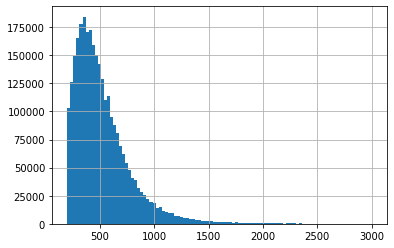

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.987045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10183
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 380


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.755320
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.4275
[100]	valid_0's huber: 64.6111
[150]	valid_0's huber: 58.1999
[200]	valid_0's huber: 54.5082
[250]	valid_0's huber: 52.2664
[300]	valid_0's huber: 50.5246
[350]	valid_0's huber: 49.0294
[400]	valid_0's huber: 47.9093
[450]	valid_0's huber: 46.9817
[500]	valid_0's huber: 46.195
[550]	valid_0's huber: 45.3935
[600]	valid_0's huber: 44.7129
[650]	valid_0's huber: 44.1256
[700]	valid_0's huber: 43.6551
[750]	valid_0's huber: 43.1622
[800]	valid_0's huber: 42.8101
[850]	valid_0's huber: 42.4291
[900]	valid_0's huber: 42.0886
[950]	valid_0's huber: 41.7361
[1000]	valid_0's huber: 41.4444
[1050]	valid_0's huber: 41.1641
[1100]	valid_0's huber: 40.9465
[1150]	valid_0's huber: 40.6666
[1200]	valid_0's huber: 40.4403
[1250]	valid_0's huber: 40.2225
[1300]	valid_0's huber: 40.0165
[1350]	valid_0's huber: 39.7818
[1400]	valid_0's huber: 39.5847
[1450]	v

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


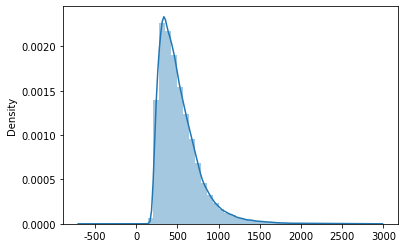

Fold 1 end
Fold 2 start
y dist plot


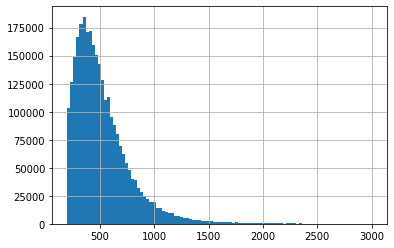

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.958440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10194
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 381


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.648130
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.3715
[100]	valid_0's huber: 64.4558
[150]	valid_0's huber: 58.2633
[200]	valid_0's huber: 54.6197
[250]	valid_0's huber: 52.1717
[300]	valid_0's huber: 50.4919
[350]	valid_0's huber: 49.1427
[400]	valid_0's huber: 48.026
[450]	valid_0's huber: 47.1568
[500]	valid_0's huber: 46.2345
[550]	valid_0's huber: 45.5282
[600]	valid_0's huber: 44.8641
[650]	valid_0's huber: 44.2661
[700]	valid_0's huber: 43.7207
[750]	valid_0's huber: 43.2965
[800]	valid_0's huber: 42.856
[850]	valid_0's huber: 42.4842
[900]	valid_0's huber: 42.1221
[950]	valid_0's huber: 41.7753
[1000]	valid_0's huber: 41.472
[1050]	valid_0's huber: 41.1926
[1100]	valid_0's huber: 40.9427
[1150]	valid_0's huber: 40.6707
[1200]	valid_0's huber: 40.425
[1250]	valid_0's huber: 40.1883
[1300]	valid_0's huber: 39.9485
[1350]	valid_0's huber: 39.743
[1400]	valid_0's huber: 39.5585
[1450]	valid

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


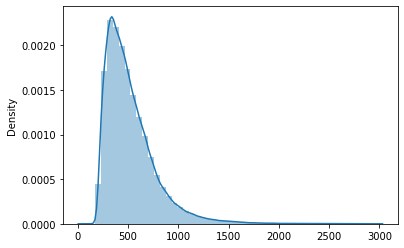

Fold 2 end
Fold 3 start
y dist plot


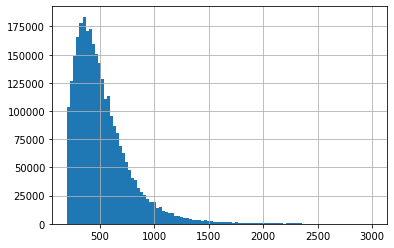

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.991682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10195
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 382


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.732369
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.3737
[100]	valid_0's huber: 64.437
[150]	valid_0's huber: 58.1738
[200]	valid_0's huber: 54.5741
[250]	valid_0's huber: 52.1914
[300]	valid_0's huber: 50.2743
[350]	valid_0's huber: 48.9601
[400]	valid_0's huber: 47.943
[450]	valid_0's huber: 47.0171
[500]	valid_0's huber: 46.1868
[550]	valid_0's huber: 45.4646
[600]	valid_0's huber: 44.8091
[650]	valid_0's huber: 44.3102
[700]	valid_0's huber: 43.7685
[750]	valid_0's huber: 43.3427
[800]	valid_0's huber: 42.9095
[850]	valid_0's huber: 42.5081
[900]	valid_0's huber: 42.1569
[950]	valid_0's huber: 41.7995
[1000]	valid_0's huber: 41.4899
[1050]	valid_0's huber: 41.1841
[1100]	valid_0's huber: 40.9016
[1150]	valid_0's huber: 40.6655
[1200]	valid_0's huber: 40.429
[1250]	valid_0's huber: 40.2308
[1300]	valid_0's huber: 40.0105
[1350]	valid_0's huber: 39.8263
[1400]	valid_0's huber: 39.6629
[1450]	val

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


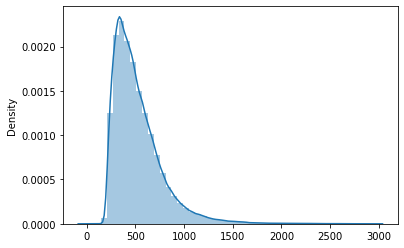

Fold 3 end
Fold 4 start
y dist plot


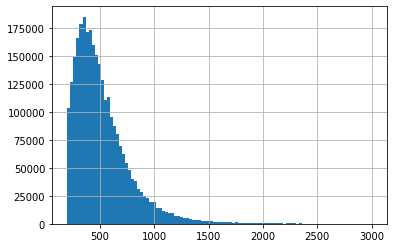

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.920934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 382


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.646665
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.2449
[100]	valid_0's huber: 64.4939
[150]	valid_0's huber: 58.3717
[200]	valid_0's huber: 54.6162
[250]	valid_0's huber: 52.2921
[300]	valid_0's huber: 50.3918
[350]	valid_0's huber: 49.0911
[400]	valid_0's huber: 47.9873
[450]	valid_0's huber: 46.9567
[500]	valid_0's huber: 46.1035
[550]	valid_0's huber: 45.4299
[600]	valid_0's huber: 44.7772
[650]	valid_0's huber: 44.1939
[700]	valid_0's huber: 43.7163
[750]	valid_0's huber: 43.3049
[800]	valid_0's huber: 42.8646
[850]	valid_0's huber: 42.4909
[900]	valid_0's huber: 42.1081
[950]	valid_0's huber: 41.8389
[1000]	valid_0's huber: 41.5209
[1050]	valid_0's huber: 41.2402
[1100]	valid_0's huber: 40.9791
[1150]	valid_0's huber: 40.7468
[1200]	valid_0's huber: 40.4976
[1250]	valid_0's huber: 40.2452
[1300]	valid_0's huber: 40.0294
[1350]	valid_0's huber: 39.8491
[1400]	valid_0's huber: 39.6683
[1450]	

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


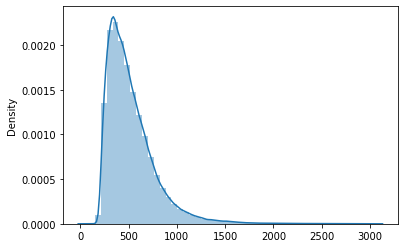

Fold 4 end


<Figure size 432x288 with 0 Axes>

In [21]:
count = 0
oof = np.zeros(training_data_df.shape[0])

shap_summary_df = pd.DataFrame()

for train_idx, val_idx in kf.split(training_data_df):
    print('Fold {} start'.format(count))
    train_data = training_data_df.loc[train_idx]
    val_data = training_data_df.loc[val_idx]
    
    x_train = train_data.drop(columns=target_cols)
    y_train = train_data['가격면적']
    
    x_val = val_data.drop(columns=target_cols)
    y_val = val_data['가격면적']
    
    print('y dist plot')
    y_train.hist(bins=100)
    plt.show()
    plt.clf()
    
    params = {
        'objective': 'huber',
        'learning_rate': 10,
        'seed': 42,
        'max_depth': 12,
        'num_leaves': 37,
        'lambda_l2': 0,
        'metric': 'huber',
        'num_threads': 6,
    }
    
    train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
    val_dataset = lgb.Dataset(x_val, label=y_val, categorical_feature=cat_cols)
    
    num_rounds = 10000

    bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[val_dataset], early_stopping_rounds=500, verbose_eval=50)
    
    bst.save_model(basedir + 'lightgbm_huber_feature_selection_practice_model_{}.txt'.format(count), num_iteration=bst.best_iteration)
    
    preds = bst.predict(x_val, num_iteration=bst.best_iteration)
    
    print('preds dist plot')
    sns.distplot(preds)
    plt.show()
    plt.clf()
    
    oof[val_idx] = preds
    
    # shap
    explainer = shap.explainers.Tree(bst)
    
    sample_x = x_val.sample(n=1000)
    sample_y = y_val.loc[x_val.index]
    
    shap_values = explainer.shap_values(sample_x, y=sample_y, check_additivity=True, approximate=False)
    shap_values_T = shap_values.T
    
    shap_summary = np.zeros(x_val.shape[1])
    
    for i in range(x_val.shape[1]):
        shap_summary[i] = np.mean(np.abs(shap_values_T[i]))
    
    
    shap_summary_df['model_{}_shap_summary'.format(count)] = shap_summary
        
    
    print('Fold {} end'.format(count))
    count += 1

In [23]:
from sklearn.metrics import mean_squared_error

In [24]:
oof.shape

(3658226,)

In [28]:
np.sqrt(mean_squared_error(training_data_df['가격면적'], oof))

65.23359424124692

In [29]:
shap_summary_df.shape

(399, 5)

In [30]:
shap_summary_mean = np.zeros(shap_summary_df.shape[0])
for i in range(shap_summary_df.shape[1]):
    shap_summary_mean += shap_summary_df.iloc[:,i]

In [32]:
shap_summary_mean = shap_summary_mean / shap_summary_df.shape[1]

In [35]:
shap_summary_df.head()

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary
0,39.238704,37.367223,40.471796,38.169571,39.531332
1,4.472709,4.795792,5.369097,4.725520,4.664758
2,47.382718,49.343322,49.110734,48.584290,47.759808
3,3.089907,2.201902,2.586846,2.889645,2.403864
4,3.705040,2.832465,3.060137,3.657026,3.089195


In [34]:
shap_summary_mean[:5]

0    38.955725
1     4.805575
2    48.436175
3     2.634433
4     3.268773
Name: model_0_shap_summary, dtype: float64

In [36]:
shap_summary_df['shap_summary_mean'] = shap_summary_mean

In [38]:
shap_summary_df.index = x_train.columns

In [39]:
shap_summary_df.head()

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
전용면적,39.238704,37.367223,40.471796,38.169571,39.531332,38.955725
층,4.472709,4.795792,5.369097,4.725520,4.664758,4.805575
건축년도,47.382718,49.343322,49.110734,48.584290,47.759808,48.436175
전용면적_mean,3.089907,2.201902,2.586846,2.889645,2.403864,2.634433
전용면적_min,3.705040,2.832465,3.060137,3.657026,3.089195,3.268773


In [40]:
shap_summary_df.to_csv(basedir + 'shap_summary.csv')

In [42]:
# Next things to do:
# 1. Do Variance Inflation Factor (VIF) analysis.
# 2. keep the feature with the highest shap value
# 3. Retrain
# 4. Remove 1 feature at a time and find out the set of feature with the lowest loss.
# 5. Retrain
# 6. Continue production prep

In [41]:
# Variance Inflation Factor analysis

In [43]:
x_data = training_data_df.drop(columns=target_cols)

In [44]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [46]:
vif_df = pd.DataFrame()

vif = []
for i in tqdm(range(x_data.shape[1])):
    vif.append(variance_inflation_factor(x_data.values, i))

vif_df["VIF"] = vif

vif_df["features"] = x_data.columns

  0%|                                                                                          | 0/399 [00:54<?, ?it/s]


MemoryError: Unable to allocate 10.9 GiB for an array with shape (3658226, 399) and data type float64

In [ ]:
over_zero_df = shap_summary_df[shap_summary_df[0] > 0]
over_zero_df.shape

In [ ]:
over_zero_df = over_zero_df.transpose()
over_zero_df.head()

In [ ]:
over_zero_df.to_csv(basedir + 'over_zero_shap_score_features.csv', index=False)

In [ ]:
selected_features = over_zero_df.columns.tolist()

In [ ]:
test_data = training_data_df.sample(frac=0.2)
train_data = training_data_df.drop(test_data.index)
valid_data = train_data.sample(frac=0.2)
train_data = train_data.drop(valid_data.index)
print(test_data.shape)
print(valid_data.shape)
print(train_data.shape)

In [ ]:
x_test = test_data[selected_features]
y_test = test_data['가격면적']
print(x_test.shape)
print(y_test.shape)

In [ ]:
x_valid = valid_data[selected_features]
y_valid = valid_data['가격면적']
print(x_valid.shape)
print(y_valid.shape)

In [ ]:
x_train = train_data[selected_features]
y_train = train_data['가격면적']
print(x_train.shape)
print(y_train.shape)

In [ ]:
y_train.hist(bins=100)

In [ ]:
import lightgbm as lgb

In [ ]:
params = {
    'objective':'regression',
    'learning_rate': 0.03,
    'seed': 42,
    'max_depth': -1,
    'num_leaves':31,
    'lambda_l2':0,
    'metric':'rmse',
    'tree_learner':'feature'
}

In [ ]:
cat_cols = [col for col in cat_cols if col in selected_features]
len(cat_cols)

In [ ]:
train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
valid_dataset = lgb.Dataset(x_valid, label=y_valid, categorical_feature=cat_cols)

In [ ]:
# without 토지면적 log
num_rounds = 500000

bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[valid_dataset], early_stopping_rounds=5000, verbose_eval=50)

In [ ]:
lgb.plot_importance(bst)

In [ ]:
preds = bst.predict(x_test, num_iteration=bst.best_iteration)

In [ ]:
bst.save_model('lgb_model_for_training_data_ver_8.txt')

In [ ]:
pd.DataFrame(y_test).to_csv('y_test_training_data_ver_8.csv', index=False)

In [ ]:
pd.DataFrame({'preds':preds}).to_csv('lgb_preds_training_data_ver_8.csv', index=False)

In [ ]:
y_test_pricearea = test_data['가격/면적']

In [ ]:
r2_score(y_test, preds)

In [ ]:
r2_score(y_test_pricearea, np.e**preds)

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
mean_squared_error(y_test, preds)

In [ ]:
mean_squared_error(y_test_pricearea, np.e**preds)

In [ ]:
compare_df = pd.DataFrame({'y_test':y_test, 'preds':preds})
print(compare_df.shape)
compare_df.head(50)

In [ ]:
compare_df.tail()

In [ ]:
mean_squared_error(y_test, pred)

In [ ]:
from sklearn.metrics import mean_squared_log_error

In [ ]:
mean_squared_log_error(y_test, pred)

In [ ]:
pred_df = pd.DataFrame({'pred':pred})
print(pred_df.shape)
pred_df.head()

In [ ]:
negative_df = pred_df[pred_df['pred'] < 0]
print(negative_df.shape)

In [ ]:
negative_df

In [ ]:
y_test_df = pd.DataFrame({'y_test':y_test}).reset_index(drop=True)
print(y_test_df.shape)
y_test_df.head()

In [ ]:
y_test_df.loc[negative_df.index,:]

In [ ]:
col_map

In [ ]:
x_test.loc[y_test.iloc[negative_df.index].index,:]

# CatBoost

In [ ]:
from catboost import Pool, CatBoostRegressor

In [ ]:
train_pool = Pool(x_train, y_train, cat_features=cat_cols)
val_pool = Pool(x_valid, y_valid, cat_features=cat_cols)
test_pool = Pool(x_test, y_test, cat_features=cat_cols)

In [ ]:
model = CatBoostRegressor(iterations=1000000, learning_rate=0.3, l2_leaf_reg=0.01)#, rsm=0.8)

In [ ]:
model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100, plot=True, verbose=False)

In [ ]:
%%time
shap_values = model.get_feature_importance(data=val_pool, type='ShapValues')

In [ ]:
shap_values.shape

In [ ]:
val_pool.shape

In [ ]:
import shap

In [ ]:
explainer = shap.TreeExplainer(model)

In [ ]:
colnames_map_df = pd.DataFrame({'colnames':x_valid.columns,'map':[i for i in range(len(x_valid.columns))]})
colnames_map_df.head()

In [ ]:
x_valid.columns = colnames_map_df['map'].tolist()
x_valid.head()

In [ ]:
summary = shap.summary_plot(shap_values[:,:-1], x_valid, max_display=x_valid.shape[1])

In [ ]:
shap_values_df = pd.DataFrame(shap_values[:,:-1])
shap_values_df.head()

In [ ]:
shap_summary_df = pd.DataFrame()

In [ ]:
np.mean(np.abs(shap_values_df[0].values))

In [ ]:
for col in shap_values_df.columns:
    shap_summary_df[col] = [np.mean(np.abs(shap_values_df[col].values))]

In [ ]:
shap_summary_df

In [ ]:
shap_summary_df = shap_summary_df.transpose().sort_values([0], ascending=False)

In [ ]:
shap_summary_df.head()

In [ ]:
selected_features_map = shap_summary_df.index[:330].values

In [ ]:
selected_features_list = []
for v in selected_features_map:
    selected_features_list.append(colnames_map_df.iloc[v,0])

In [ ]:
selected_features_list

In [ ]:
selected_features_df = pd.DataFrame({'colnames':selected_features_list})
selected_features_df.head()

In [ ]:
selected_features_df.to_csv(basedir + 'selected_features.csv', index=False)

In [ ]:
test_data = training_data_df.sample(frac=0.2)
train_data = training_data_df.drop(test_data.index)
valid_data = train_data.sample(frac=0.2)
train_data = train_data.drop(valid_data.index)
print(test_data.shape)
print(valid_data.shape)
print(train_data.shape)

In [ ]:
x_test = test_data[selected_features_list]
y_test = test_data['가격면적']
print(x_test.shape)
print(y_test.shape)

In [ ]:
x_valid = valid_data[selected_features_list]
y_valid = valid_data['가격면적']
print(x_valid.shape)
print(y_valid.shape)

In [ ]:
x_train = train_data[selected_features_list]
y_train = train_data['가격면적']
print(x_train.shape)
print(y_train.shape)

In [ ]:
y_train.hist(bins=100)

In [ ]:
cat_cols_df = pd.read_csv(basedir + 'cat_cols.csv')
cat_cols_df.head()

In [ ]:
cat_cols_list = [col.replace(' ','_').replace('·','_') for col in cat_cols_df['colname'].tolist()]
len(cat_cols_list)

In [ ]:
cat_cols = [col for col in x_train.columns if col in cat_cols_list]
len(cat_cols)

# CatBoost

In [ ]:
from catboost import Pool, CatBoostRegressor

In [ ]:
train_pool = Pool(x_train, y_train, cat_features=cat_cols)
val_pool = Pool(x_valid, y_valid, cat_features=cat_cols)
test_pool = Pool(x_test, y_test, cat_features=cat_cols)

In [ ]:
model = CatBoostRegressor(iterations=1000000, learning_rate=0.3, l2_leaf_reg=0.001, depth=7, rsm=0.8)

In [ ]:
model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100, plot=True, verbose=False)